In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import math

In [573]:
# Constants:
COOP = 1
DEF = 0
T = 5
R = 3 
P = 2 
S = 1 

def distributePrize(me, them):
    if me == them == COOP:
        return R
    if (me == COOP) and (them == DEF):
        return S
    if (me == DEF) and (them == COOP):
        return T
    return P

## Rules:
### Cooperate Unconditionally (Cu)
Always cooperate
### Defect Unconditionally (Du)
Always defect
### Rand
Random choice
### Cooperate probability (Cp)
Cooperate a percentage of the time
### Tit for tat (TFT)
Starts with cooperate, then copies other players previous move
### Suspicious TFT (STFT)
TFT but starts with defect
### Gradual TFT (GrdTFT)
TFT, but every time they defect you defect, and if they defect multiple times you follow with a chain of defections equal to the number of times they defected. After this chain is finished, cooperate twice in a row as an apology

In [543]:
class Agent:
    def __init__(self):
        self.score = 0
        self.past = []
        self.againstAgentScore = {}
        self.againstAgentWins = {}
    
    def reset(self):
        self.score = 0
    
    def playMove(self, them, rn):
        return self.rule(them, rn)

    def addScore(self, result):
        self.score += result

    def getScore(self):
        return self.score

    def finishGame(self, score, outcome, enemy):
        # Outcome == 1 if won, 0 if lost
        self.againstAgentScore[enemy] = self.againstAgentScore.get(enemy, 0) + score
        self.againstAgentWins[enemy] = self.againstAgentWins.get(enemy, 0) + outcome
        self.reset()

class Cu(Agent):
    def rule(self, them, rn):
        return COOP
    def __repr__(self):
        return "Cooperate unconditionally"
    def short(self):
        return 'cu'

class Du(Agent):
    def rule(self, them, rn):
        return DEF
    def __repr__(self):
        return "Defect unconditionally"
    def short(self):
        return 'du'

class Rand(Agent):
    def rule(self, them, rn):
        return random.randint(0,2)
    def __repr__(self):
        return "Random"
    def short(self):
        return 'rand'

class Cp(Agent):
    def rule(self, them, rn):
        if random.rand() >= .75:
            return COOP
        return DEF
    def __repr__(self):
        return "Cooperate probabilistically"
    def short(self):
        return 'cp'

class TFT(Agent):
    def rule(self, them, rn):
        if rn == 0: return COOP
        else: return them[-1]
    def __repr__(self):
        return "Tit for Tat"
    def short(self):
        return 'tft'

class STFT(Agent):
    def rule(self, them, rn):
        if rn == 0: return DEF
        return them[-1]
    def __repr__(self):
        return "Suspicious Tit for Tat"
    def short(self):
        return 'stft'

AGENTTYPES = {'du':Du, 'cu':Cu, 'rand':Rand, 'cp':Cp, 'tft':TFT, 'stft':STFT}

In [715]:
class AgentBuilder:
    def xOfEach(self, *args):
        agents = ''
        filename = 'game'
        for arg in args:
            name = f"{arg[0].lower().strip()} "
            agents += name*arg[1]
            filename += f'{arg[1]}{arg[0].lower().strip()}'
        filename += ".png"
        return agents, filename

    def rand(self, num):
        names = np.array(list(AGENTTYPES.keys()))
        agents = random.choice(names, size=num)
        unique, counts = np.unique(agents, return_counts=True)
        ags = dict(zip(unique, counts))
        filename = 'game'
        agentStr = ''
        for name, count in ags.items():
            agentStr += (f'{name} '*count)
            filename += f'{count}{name}'
        filename += '.png'
        return agentStr, filename

In [713]:
agb = AgentBuilder()
agents, _ = agb.rand(10)

cp cu du du du rand stft stft stft tft 


In [886]:
class Arbiter:
    # Manages games between two agents
    def __init__(self, rounds):
        self.rounds = rounds
        self.overallscores = {}
        self.wins = {}
        self.agents = {}

    def playNMatches(self, a1, a2, N):
        self.agents.update({a1:a1})
        self.agents.update({a2:a2})
        for _ in range(N):
            self.playMatch(a1, a2)
    
    def playMatch(self, a1, a2):
        a1past = []
        a2past = []

        for n in range(self.rounds):
            a1past, a2past = self.playOneGame(a1, a1past, a2, a2past, n)

        a1score = a1.getScore()
        a2score = a2.getScore()
        self.overallscores[a1] = self.overallscores.get(a1, 0) + a1score
        self.overallscores[a2] = self.overallscores.get(a2, 0) + a2score

        a1win, a2win = 0, 0
        if a1score > a2score: a1win = 1
        else: a2win = 1
        self.wins[a1] = self.wins.get(a1, 0) + a1win
        self.wins[a2] = self.wins.get(a2, 0) + a2win
        a1.finishGame(a1score, a1win, a2)
        a2.finishGame(a2score, a2win, a1)
        
    def playOneGame(self, a1, a1past, a2, a2past, roundnum):
        m1 = a1.rule(a2past, roundnum)
        m2 = a2.rule(a1past, roundnum)
        a1past.append(m1)
        a2past.append(m2)
        a1.addScore(distributePrize(m1, m2))
        a2.addScore(distributePrize(m2, m1))
        return a1past, a2past

    def displayScores(self):
        print("Overall Scores: ",self.overallscores)
        for agent in self.agents:
            print(f"Agent {agent} score {self.overallscores[agent]}, broken up as: {agent.againstAgentScore}")
        print("Wins:", self.wins)

    def roundRobinScheduler(self, players):
        if players % 2 == 1: players += 1
        half = players//2
        days = []
        for x in range(players-1, -1, -1):
            first = [0]*half
            second = []
            count = 0
            for n in range(x+half,x+half-players,-1):
                player = n%players
                if player == 0:
                    continue
                elif count < half-1:
                    first[half-count-1] = player
                    count += 1
                else:
                    second.append(player)
            days.append([first,second])
        days.pop(half)
        return days

    def scheduleGames(self, days):
        games = []
        matches = len(days[0][0])
        for day in days:
            for match in range(matches):
                games.append([day[0][match],day[1][match]])
        return games
            
    def parseAgentString(self, string):
        names = string.lower().strip().split(' ')
        print(names)
        agents = []
        for name in names:
            agents.append(AGENTTYPES[name]())
        return agents

    def playTournament(self, agentStr, N, filename, text=False):
        agents = self.parseAgentString(agentStr)
        roundRobinGames = self.scheduleGames(self.roundRobinScheduler(len(agents)))
        for game in roundRobinGames:
            self.playNMatches(agents[game[0]], agents[game[1]], N)
        self.graphScores(agents, filename, text)
        return agents

    def graphScores(self, agents, filename, labels=True):
        grid = np.zeros((len(agents) + 1, len(agents)))
        scores = np.zeros(len(agents))
        for idx, agent in enumerate(agents):
            print(f"Agent {agent} is index {idx}")
            for idx2 in range(len(agents)):
                if idx==idx2: continue
                grid[idx2, idx] = agent.againstAgentScore[agents[idx2]]
            scores[idx] = (self.overallscores[agent])
        fig, ax = plt.subplots(figsize=(13,13))
        plt.imshow(grid,cmap='plasma')
        plt.colorbar()
        plt.xlabel('agent')
        plt.ylabel('opponent')
        if labels:
            for i in range(grid.shape[0]-1):
                for j in range(grid.shape[1]):
                    text = ax.text(j, i, f"{agents[j].short()} vs {agents[i].short()}\n{grid[i, j]/10000}", ha="center", va="center", color="k", rotation=-10)
            for i in range(grid.shape[1]):
                text = ax.text(i, grid.shape[1], f"{agents[i].short()}\n{scores[i]/10000}", ha="center", va="center", color="w", rotation=-10)
        title = 'Graph read as: X axis is the agent in question, and the y axis is who they played against. \nThe higher the number, the more they scored against that opponent.\nThe last row is the agent\'s total score.\n'
        agnames = []
        for agent in agents: agnames.append(agent.short())
        unique, counts = np.unique(agnames, return_counts=True)
        ags = dict(zip(unique, counts))
        for name, count in ags.items():
            title += f"{count} {name}, "
        plt.title(title[:-2])
        plt.savefig(filename)
        print(title)

In [888]:
arb = Arbiter(1000)
agb = AgentBuilder()

['cp', 'cp', 'cp', 'cu', 'cu', 'cu', 'du', 'rand', 'stft', 'tft']
Agent Cooperate probabilistically is index 0
Agent Cooperate probabilistically is index 1
Agent Cooperate probabilistically is index 2
Agent Cooperate unconditionally is index 3
Agent Cooperate unconditionally is index 4
Agent Cooperate unconditionally is index 5
Agent Defect unconditionally is index 6
Agent Random is index 7
Agent Suspicious Tit for Tat is index 8
Agent Tit for Tat is index 9
Graph read as: X axis is the agent in question, and the y axis is who they played against. 
The higher the number, the more they scored against that opponent.
The last row is the agent's total score.
3 cp, 3 cu, 1 du, 1 rand, 1 stft, 1 tft, 


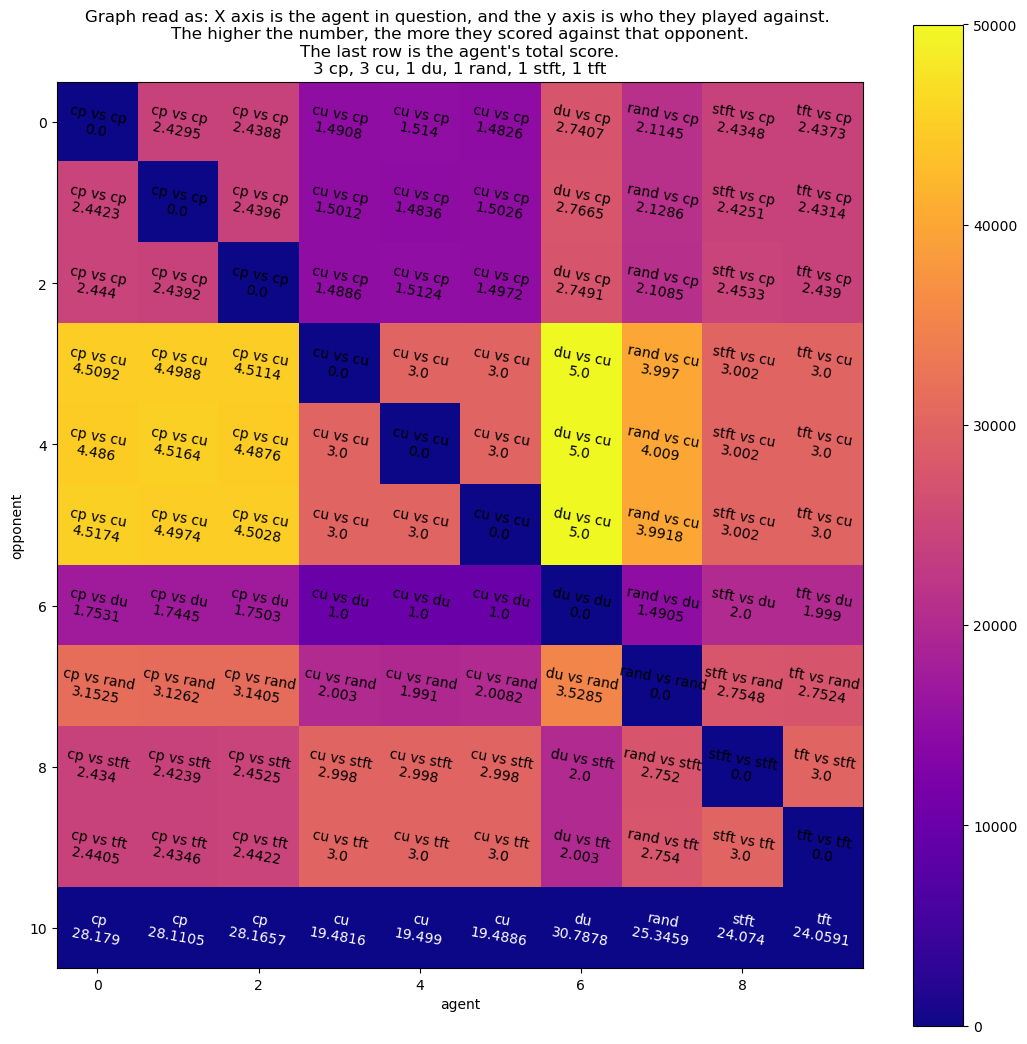

In [890]:
agentStr, filename = agb.rand(10)
agents = arb.playTournament(agentStr, 10, filename, text=True)

['du', 'du', 'du', 'tft', 'tft', 'tft']
Agent Defect unconditionally is index 0
Agent Defect unconditionally is index 1
Agent Defect unconditionally is index 2
Agent Tit for Tat is index 3
Agent Tit for Tat is index 4
Agent Tit for Tat is index 5
Graph read as: X axis is the agent in question, and the y axis is who they played against. 
The higher the number, the more they scored against that opponent.
The last row is the agent's total score.
3 du, 3 tft, 


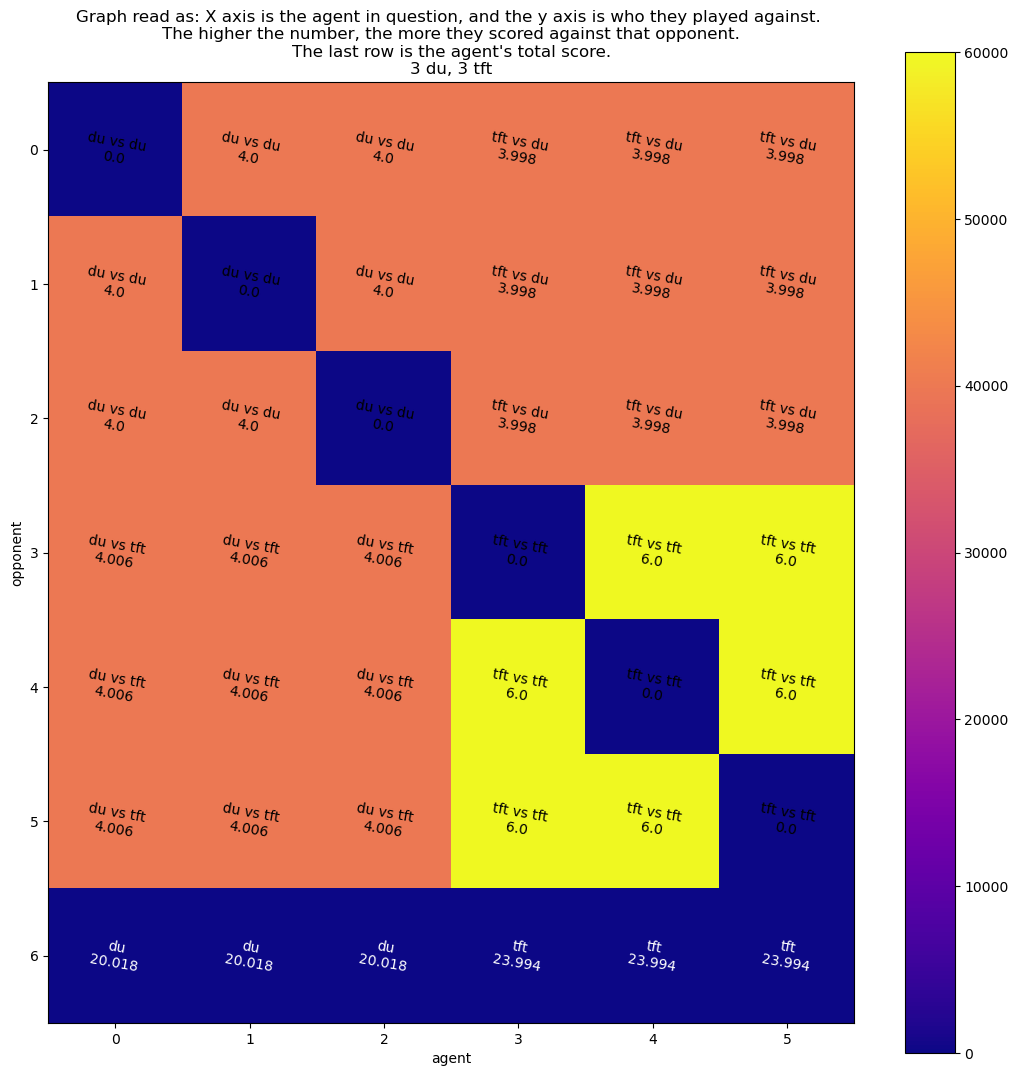

In [865]:
agentStr, filename = agb.xOfEach(('du', 3), ('tft', 3))
agents = arb.playTournament(agentStr, 20, filename, text=True)

## Future
5 generally cooperative, 5 generally uncooperative and then round robin
make function to play round robin with an array of agents
3tft and 3DUs - good sanity check! 3 tft should win. Du wont make much off of other DUs and only a little against tft. Tft will make lots off the other tft

Big question: What strategies thrive in what conditions? In what conditions will TFT show its value? Are there conditions where CU is better? What agents do best where?